# Analysis of the bus data collected by data-collector

## Preparation

### Load data from a file generated by data collector

In [187]:
import json

with open('data/evening_data.json', 'r') as json_file:
    json_data = json.load(json_file)

### Lets define a method that calculates distance between 2 points on earth

In [188]:
import numpy as np

def calculate_distance(lat_a, lon_a, lat_b, lon_b):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude to radians
    lat_a, lon_a, lat_b, lon_b = np.radians([lat_a, lon_a, lat_b, lon_b])
    
    # Calculate the difference in latitude and longitude
    dlat = lat_b - lat_a
    dlon = lon_b - lon_a
    
    # Apply the Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat_a) * np.cos(lat_b) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

### Some tests

In [189]:
def test_distance_between_the_same_points():
    lat_a, lon_a = 52.52, 13.405
    
    expected_distance = 0
    calculated_distance = calculate_distance(lat_a, lon_a, lat_a, lon_a)
    assert np.isclose(calculated_distance, expected_distance, atol=0.001)
    
def test_distance_between_cities():
    lat_a, lon_a = 52.52, 13.405  # Berlin
    lat_b, lon_b = 48.8566, 2.3522  # Paris
    
    expected_distance = 878.7
    calculated_distance = calculate_distance(lat_a, lon_a, lat_b, lon_b)
    assert np.isclose(calculated_distance, expected_distance, atol=10)

In [190]:
test_distance_between_the_same_points()
test_distance_between_cities()

## Process data

### For each point calculate speed of the bus at that moment

In [191]:
import pandas as pd

def calculate_speed(df):
    df = df.copy()
    
    # Convert time to pandas time type.
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    # Drop rows with missing or invalid datetime.
    df = df.dropna(subset=['Time'])

    # Sort by vehicles and time.
    df.sort_values(by=['VehicleNumber', 'Time'], inplace=True)

    # Calculate distance between two consecutive points for each vehicle.
    df['distance'] = np.hstack(df.groupby('VehicleNumber')
                                 .apply(lambda x: calculate_distance(x['Lat'],
                                                                     x['Lon'],
                                                                     x['Lat'].shift(),
                                                                     x['Lon'].shift()))
                                 .values)

    # Calculate time difference between consecutive points (in hours).
    df['time_diff'] = df.groupby('VehicleNumber')['Time'].diff().dt.total_seconds() / 3600

    # Calculate speed (in km/h)
    df['speed'] = df['distance'] / df['time_diff']

    # Remove points with no speed.
    df = df.dropna(subset=['speed'])
    
    return df

### It's the most important part of the code. We need to test it.

In [192]:
def test_calculate_speed():
    lat_a = 52.179989
    lon_a = 21.0238
    lat_b = 52.184197
    lon_b = 20.9608521
    
    dist = calculate_distance(lat_a, lon_a, lat_b, lon_b)
    expected_speed = dist / 0.5 # we take half an our interval
    mock_data = [
        {
            "Time": "2024-02-20 20:01:56",
            "VehicleNumber": "9342",
            "Lines": "739",
            "Brigade": "4",
            "Lat": lat_a,
            "Lon": lon_a
        },
        {
            "Time": "2024-02-20 20:31:56",
            "VehicleNumber": "9342",
            "Lines": "739",
            "Brigade": "4",
            "Lat": lat_b,
            "Lon": lon_b
        }
    ]
    
    df = pd.DataFrame(mock_data)
    
    df = calculate_speed(df)
    
    assert 'speed' in df.columns
    
    index = df['speed'].first_valid_index()
    speed = df.at[index, 'speed']
    
    assert expected_speed == speed

In [193]:
test_calculate_speed()

### After testing we can use it on our data

In [194]:
df = pd.DataFrame(json_data)

import cProfile
from pstats import Stats

profiler = cProfile.Profile()

profiler.enable()
df = calculate_speed(df)
profiler.disable()

stats = Stats(profiler)

### We can check some rows.

In [195]:
df

,Time,VehicleNumber,Lines,Brigade,Lat,Lon,distance,time_diff,speed
171228,2024-02-20 23:16:40,1000,213,3,52.182810,21.209041,0.141898,0.005556,25.541623
56153,2024-02-20 23:17:00,1000,213,3,52.182731,21.211183,0.146302,0.005556,26.334443
7828,2024-02-20 23:17:20,1000,213,3,52.182569,21.213811,0.180077,0.005556,32.413862
167015,2024-02-20 23:17:40,1000,213,3,52.182413,21.216848,0.207785,0.005556,37.401292
173899,2024-02-20 23:18:00,1000,213,3,52.182281,21.219339,0.170468,0.005556,30.684153
...,...,...,...,...,...,...,...,...,...
24007,2024-02-21 00:13:28,9955,114,6,52.279404,20.874617,0.000900,0.008333,0.107989
50737,2024-02-21 00:13:59,9955,114,6,52.279415,20.874615,0.001231,0.008611,0.142919
43905,2024-02-21 00:14:29,9955,114,6,52.279419,20.874601,0.001051,0.008333,0.126139
168938,2024-02-21 00:14:59,9955,114,6,52.279423,20.874580,0.001496,0.008333,0.179553


### And we can check the profiling results

In [196]:
stats.print_stats()

         831508 function calls (827753 primitive calls) in 0.651 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
     7139    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
     3557    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        4    0.005    0.001    0.005    0.001 {method 'clear' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
     7164    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
       27    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
        2    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
       20    0.0

## Analysis of speeds of the buses

### How many buses have exceeded 50km/h?

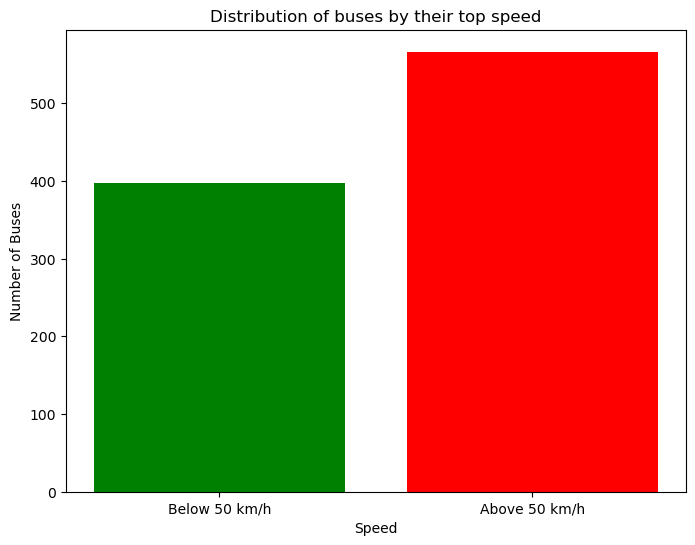

In [197]:
# Get all points with exceeded speed limit.
df_exceeded = df[df['speed'] > 50]

# Total number of buses
number_of_buses_total = df["VehicleNumber"].nunique()

# Number of buses that exceeded the speed limit.
number_of_buses_exceeded = df_exceeded["VehicleNumber"].nunique()


import matplotlib.pyplot as plt

# Plot.
plt.figure(figsize=(8, 6))
plt.bar(['Below 50 km/h', 'Above 50 km/h'],
        [number_of_buses_total - number_of_buses_exceeded, number_of_buses_exceeded],
        color=['green', 'red'])
plt.xlabel('Speed')
plt.ylabel('Number of Buses')
plt.title('Distribution of buses by their top speed')
plt.show()

### In what locations more than 50% of buses have exceeded the speed limit?

Lets define a location as a square with a middle point `p` and side `a`

### Find locations

In [198]:
def find_locations():
    # Side of the square in degrees on earth surface
    a = 0.002

    # Percentage
    p = 50

    # Middle points of locations with high percentage of speeding.
    locations = []

    # Lets use R-Tree to count quiqly the number of points within a square.

    from rtree import index

    p_index_all = index.Index()
    p_index_exceeded = index.Index()

    for idx, row in df.iterrows():
        lat = row['Lat']
        lon = row['Lon']
        p_index_all.insert(idx, (lon, lat, lon, lat))

    for idx, row in df_exceeded.iterrows():
        lat = row['Lat']
        lon = row['Lon']
        p_index_exceeded.insert(idx, (lon, lat, lon, lat))

    for idx, row in df.iterrows():
        lat = row['Lat']
        lon = row['Lon']

        # All points within the square centered in the point.
        neighbors_all = list(p_index_all.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))

        # Points with exceeded speed limit within the square centered in the point.
        neighbors_exceeded = list(
            p_index_exceeded.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))


        if (len(neighbors_exceeded) / len(neighbors_all)) * 100 > p:
            locations.append((lat, lon))
    
    return locations

In [199]:
profiler.clear()

profiler.enable()
locations = find_locations()
profiler.disable()

print(f"Number of locations: {len(locations)}")

Number of locations: 4912


### And check the profiling results

In [200]:
stats = Stats(profiler)
stats.print_stats()

         307 function calls (303 primitive calls) in 110.542 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {built-in method fromkeys}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.all}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.any}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000  110.542  110.542 {built-in method builtins.exec}
       13    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        1    0.000    0.000    0.000

### Show them on map of Warsaw

In [201]:
from folium import folium
from folium.plugins import HeatMap

warsaw_coordinates = (52.2297, 21.0122)

# Create a map centered around Warsaw
map_warsaw = folium.Map(location=warsaw_coordinates, zoom_start=12)

# Create heatmap data
heat_data = [[point[0], point[1]] for point in locations]

# Add heatmap layer
HeatMap(heat_data, radius=15).add_to(map_warsaw)

map_warsaw

### As expected, most of the points are located on the roads with higher speed limits.

## Bonus (additional analysis prepared by me)

Based on the analysis above, we can notice that most of the buses have exceeded the speed limit. It's good to know if that result is reliable.

### Distribution of speedings

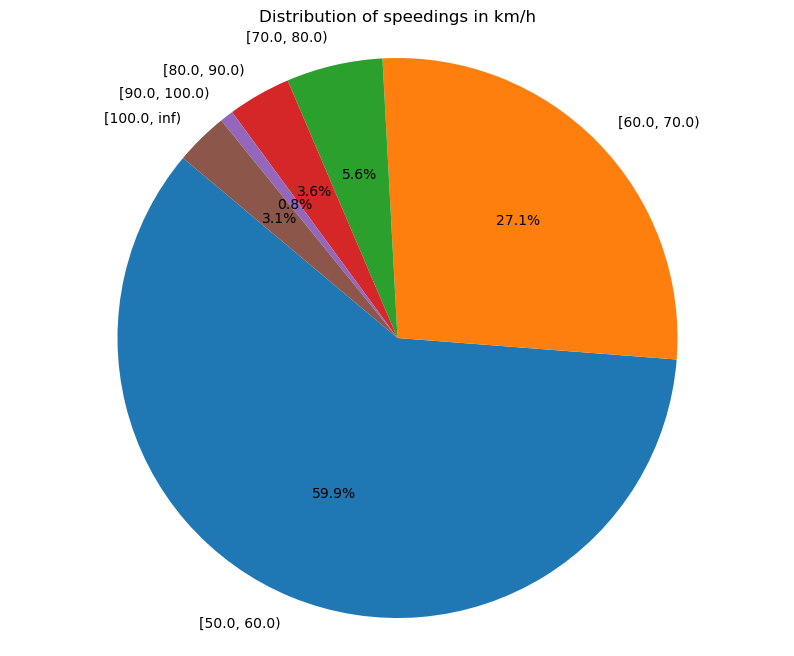

In [202]:
buckets = list(range(50, 101, 10)) + [np.inf]
speed_buckets = pd.cut(df_exceeded['speed'], bins=buckets, right=False)
speed_counts = speed_buckets.value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of speedings in km/h')
plt.axis('equal') 
plt.show()

As we can see, most of the speedings are not significant, and the number in each category is decreasing. That's why we can assume that the speedings result is reliable. Nevertheless more than 3% of speedings are speedings with speed higher than 100 km/h which is not possible. It is related to the inaccuraccy of gps positions. We can easily filter that out.

### How about other speeds?

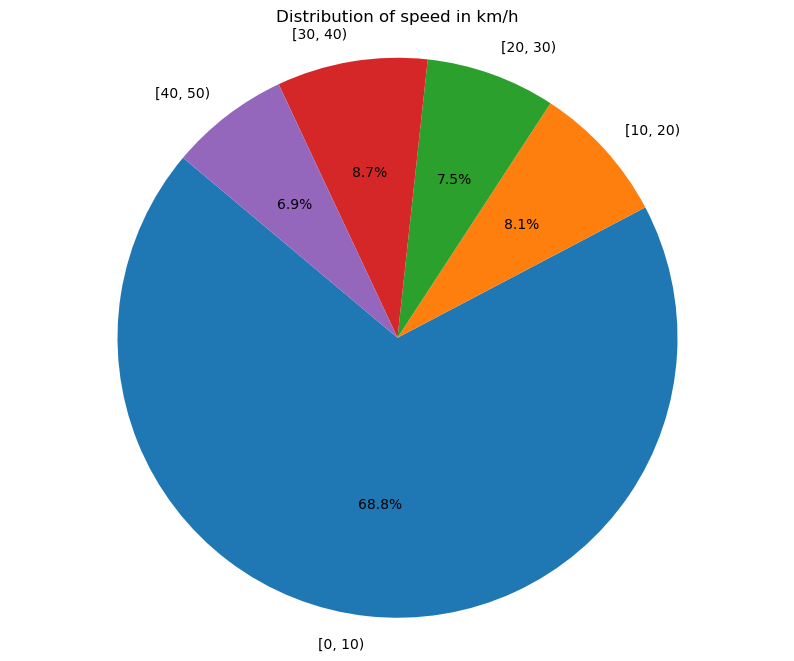

In [203]:
buckets = list(range(0, 51, 10))
speed_buckets = pd.cut(df['speed'], bins=buckets, right=False)
speed_counts = speed_buckets.value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of speed in km/h')
plt.axis('equal') 
plt.show()

Most of the time buses spend in the traffic!

### Lets make a ranking of the fastests lines.

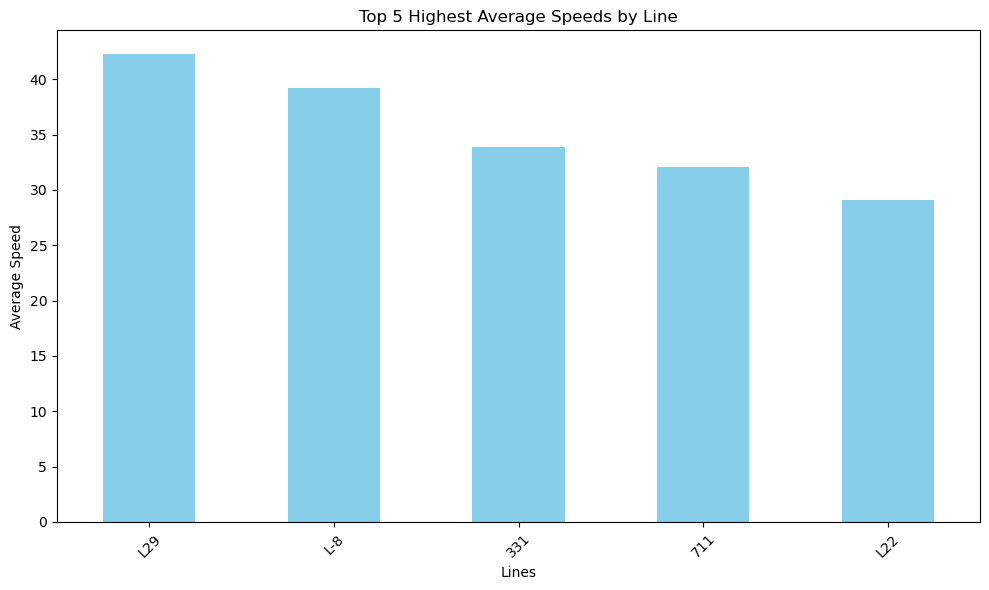

In [204]:
# Get rid of unrealistic values
df = df[df['speed'] <= 90]

speeds = df.groupby('Lines')['speed'].mean()

# Sort the speeds in descending order
sorted_speeds = speeds.sort_values(ascending=False)

# Select the top 5 highest speeds
top_5_speeds = sorted_speeds.head(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_speeds.plot(kind='bar', color='skyblue')
plt.title('Top 5 Highest Average Speeds by Line')
plt.xlabel('Lines')
plt.ylabel('Average Speed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It looks pretty reliable. The lines listed here are not placed in the centre of Warsaw.

### What about the slowest ones?

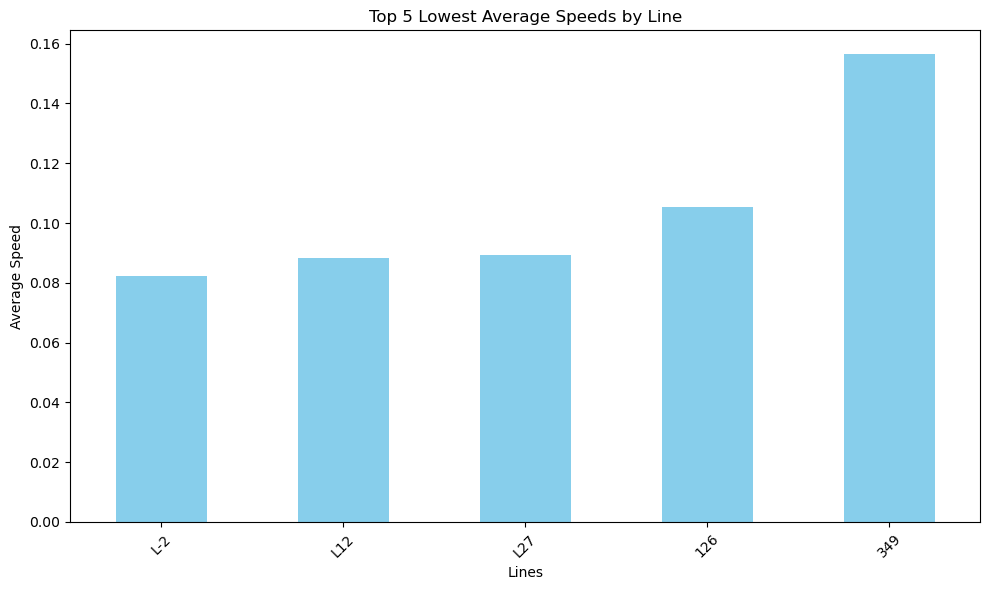

In [205]:
# Sort the speeds in ascending order
sorted_speeds = speeds.sort_values(ascending=True)

# Select the top 5 slowest speeds
top_5_speeds = sorted_speeds.head(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_speeds.plot(kind='bar', color='skyblue')
plt.title('Top 5 Lowest Average Speeds by Line')
plt.xlabel('Lines')
plt.ylabel('Average Speed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Unfortunately this one isn't reliable. It seems that in collected data those lines are staying in one place.

# THANK YOU!